In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [3]:
#Data Set Loading
try:
    df_original = pd.read_csv('obesity_prediction.csv')
    print("Data successfully loaded.")
except FileNotFoundError:
    print(f"Error: File not found in 'obesity_prediction.csv'.")
    exit()

df_original = df_original.rename(columns={'Obesity': 'Target'})

Data successfully loaded.


In [4]:
#Feature Engineering and Data Pre-Processing

X_basic = df_original.drop('Target', axis=1)
y_basic = df_original['Target']

# Categorical feature encoding
categorical_cols_basic = X_basic.select_dtypes(include=['object']).columns
for col in categorical_cols_basic:
    le = LabelEncoder()
    X_basic[col] = le.fit_transform(X_basic[col])

# Encoding target
target_encoder = LabelEncoder()
y_encoded_basic = target_encoder.fit_transform(y_basic)
class_names = target_encoder.classes_
print("Finish.")



Finish.


In [5]:
#Splitting the dataset
X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(
    X_basic, y_encoded_basic, test_size=0.2, random_state=42, stratify=y_encoded_basic
)

In [6]:
xgb_basic_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_basic_model.fit(X_train_basic, y_train_basic)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [7]:
#Evaluating Model
y_pred_basic = xgb_basic_model.predict(X_test_basic)
accuracy_basic = accuracy_score(y_test_basic, y_pred_basic)
print(f"\n>>> Base Model Accuracy: {accuracy_basic * 100:.2f}%")
print("\nClassification Results Using Basic Model:")
print(classification_report(y_test_basic, y_pred_basic, target_names=class_names))


>>> Base Model Accuracy: 95.51%

Classification Results Using Basic Model:
                     precision    recall  f1-score   support

Insufficient_Weight       0.96      0.91      0.93        54
      Normal_Weight       0.83      0.95      0.89        58
     Obesity_Type_I       0.97      0.99      0.98        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.96      0.90      0.93        58
Overweight_Level_II       0.98      0.97      0.97        58

           accuracy                           0.96       423
          macro avg       0.96      0.95      0.95       423
       weighted avg       0.96      0.96      0.96       423



#MODEL TUNING XGBOOST + GRIDSEARCHCV

In [8]:
#Feature Engineering and Data Pre-Processing

df_engineered = df_original.copy()
df_engineered['BMI'] = df_engineered['Weight'] / (df_engineered['Height'] ** 2)
print("New feature 'BMI' successfully added.")

X_tuned = df_engineered.drop('Target', axis=1)
y_tuned = df_engineered['Target']

# Categorical feature encoding
categorical_cols_tuned = X_tuned.select_dtypes(include=['object']).columns
for col in categorical_cols_tuned:
    le = LabelEncoder()
    X_tuned[col] = le.fit_transform(X_tuned[col])

# Encoding target
y_encoded_tuned = target_encoder.transform(y_tuned) # Using the same encoder
print("\nFinish.")

New feature 'BMI' successfully added.

Finish.


In [9]:
#Splitting the dataset
X_train_tuned, X_test_tuned, y_train_tuned, y_test_tuned = train_test_split(
    X_tuned, y_encoded_tuned, test_size=0.2, random_state=42, stratify=y_encoded_tuned
)

##Hyperparameter Tuning with GridSearchCV

In [10]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}
print("Processing tuning...")

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)
grid_search.fit(X_train_tuned, y_train_tuned)
print("\nFinish.")

Processing tuning...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Finish.


In [11]:
print(f"Best Parameters Found: {grid_search.best_params_}")
best_xgb_model = grid_search.best_estimator_

y_pred_tuned = best_xgb_model.predict(X_test_tuned)
accuracy_tuned = accuracy_score(y_test_tuned, y_pred_tuned)
print(f"\n>>> Accuracy of Tuning Model Results: {accuracy_tuned * 100:.2f}%")
print("\nClassification Results Using Tuning Model Results:")
print(classification_report(y_test_tuned, y_pred_tuned, target_names=class_names))

Best Parameters Found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}

>>> Accuracy of Tuning Model Results: 98.58%

Classification Results Using Tuning Model Results:
                     precision    recall  f1-score   support

Insufficient_Weight       0.98      1.00      0.99        54
      Normal_Weight       0.98      0.97      0.97        58
     Obesity_Type_I       1.00      1.00      1.00        70
    Obesity_Type_II       0.98      1.00      0.99        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.97      0.97      0.97        58
Overweight_Level_II       0.98      0.98      0.98        58

           accuracy                           0.99       423
          macro avg       0.99      0.99      0.99       423
       weighted avg       0.99      0.99      0.99       423



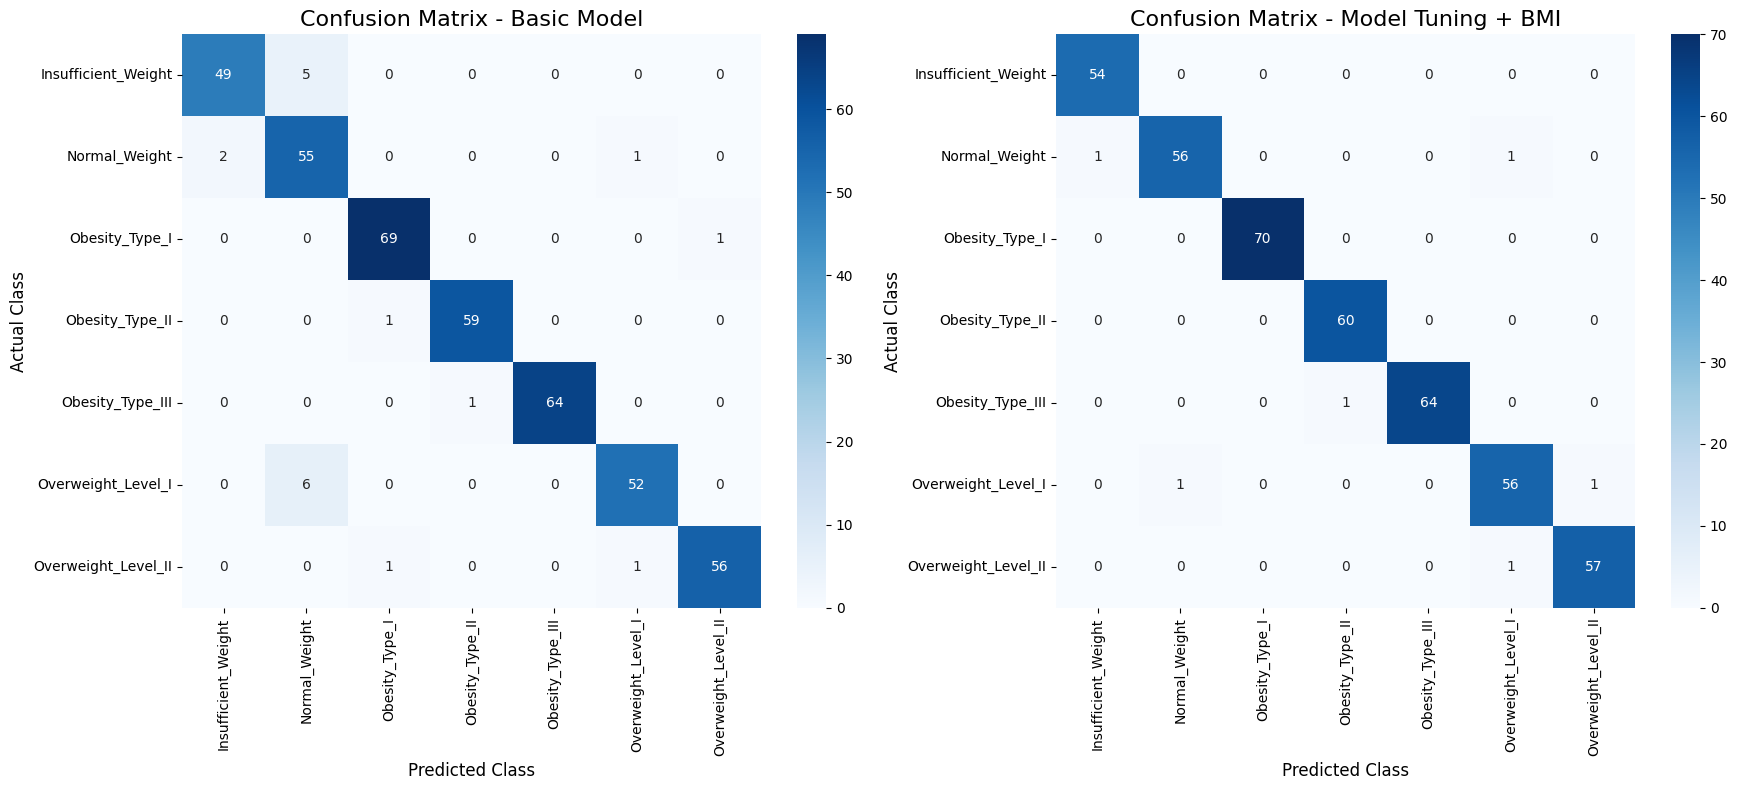

In [12]:
cm_basic = confusion_matrix(y_test_basic, y_pred_basic)
cm_tuned = confusion_matrix(y_test_tuned, y_pred_tuned)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix - Basic Model', fontsize=16)
axes[0].set_ylabel('Actual Class', fontsize=12)
axes[0].set_xlabel('Predicted Class', fontsize=12)

sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Confusion Matrix - Model Tuning + BMI', fontsize=16)
axes[1].set_ylabel('Actual Class', fontsize=12)
axes[1].set_xlabel('Predicted Class', fontsize=12)

plt.tight_layout()
plt.show()
